In [2]:
import os
import pandas as pd
import kagglehub


d:\anaconda\envs\torchnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download the dataset
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

In [4]:
train_data_folder = os.path.join(dataset_path, 'Training')
test_data_folder = os.path.join(dataset_path, 'Testing')

In [5]:
# Check if folders exist
print("Train folder exists:", os.path.exists(train_data_folder))
print("Test folder exists:", os.path.exists(test_data_folder))

Train folder exists: True
Test folder exists: True


In [6]:
# List some files
print("Train data categories:", os.listdir(train_data_folder))

Train data categories: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt

In [8]:
transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),  # Resize image
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the tensor
])

In [9]:
from PIL import Image
# Load the image
img = Image.open("images/me1.jpg")  # Add correct extension if needed (e.g., .jpg or .png)
# Apply the transforms
transformed_img = transforms(img)

print("Tensor shape:", transformed_img.shape)  # Should be [1, 224, 224] for grayscale

# Print tensor values
print("Tensor values:\n", transformed_img)

Tensor shape: torch.Size([1, 224, 224])
Tensor values:
 tensor([[[ 0.4039,  0.2471,  0.0588,  ...,  0.0588,  0.2235,  0.3961],
         [ 0.2392, -0.1216, -0.3490,  ..., -0.3647, -0.1137,  0.2235],
         [ 0.0902, -0.4275, -0.6863,  ..., -0.6941, -0.4118,  0.0745],
         ...,
         [ 0.0745, -0.3961, -0.6706,  ..., -0.7020, -0.4039,  0.0902],
         [ 0.2157, -0.1216, -0.3412,  ..., -0.3725, -0.1294,  0.2235],
         [ 0.4196,  0.2157,  0.0667,  ...,  0.0588,  0.2157,  0.4275]]])


In [10]:
train_dataset=torchvision.datasets.ImageFolder(root=train_data_folder,transform=transforms)
test_dataset=torchvision.datasets.ImageFolder(root=test_data_folder,transform=transforms)

In [11]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)

['glioma', 'meningioma', 'notumor', 'pituitary']
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Label index: 1, Class name: meningioma
torch.Size([1, 224, 224])
tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


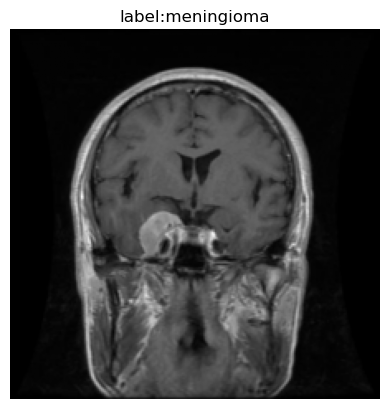

In [12]:


image, label = train_dataset[1700]
print(train_dataset.classes)
print(train_dataset.class_to_idx)
class_name = train_dataset.classes[label]
print(f"Label index: {label}, Class name: {class_name}") # Load the 5th image from the training set
print(image.shape)
print(image)

# Convert tensor to numpy array for visualization
image_np = image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image_np, cmap='gray')
plt.title(f"label:{class_name}")
plt.axis("off")
plt.show()

In [ ]:
class BTD(nn.Module):
  def __init__(self):
    super().__init__()
    self.con1d=nn.Conv2d(1,32,kernel_size=3) #output size=(32,222,222)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)#(32,111,111)
    self.con2d=nn.Conv2d(32,64,kernel_size=3)#(64,109,109) ->after pool(64,54,54)
    self.con3d=nn.Conv2d(64,128,kernel_size=3)#(128,52,52)->after pool(128,26,26)
    self.fc1 = nn.Linear(128 * 26 * 26, 512)
    self.fc2=nn.Linear(512,256)
    self.output=nn.Linear(256,4)
  def forward(self,X):
    X=self.pool(F.relu(self.con1d(X)))
    X=self.pool(F.relu(self.con2d(X)))
    X=self.pool(F.relu(self.con3d(X)))
    X = X.view(-1,128*26*26)  # Auto-flatten batch-wise

    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X = self.output(X)

    return X



In [14]:
module=BTD()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

module.to(device)

BTD(
  (con1d): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (con3d): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=4, bias=True)
)

In [16]:
optimizer=torch.optim.Adam(module.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

In [17]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


In [18]:
epochs = 12
for epoch in range(epochs):
    module.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = module(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        print(f"Batch loss: {loss.item():.4f}")  # Batch-wise loss

    # Epoch loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


Batch loss: 1.3891
Batch loss: 1.9605
Batch loss: 1.5124
Batch loss: 1.3919
Batch loss: 1.2780
Batch loss: 1.0950
Batch loss: 1.1138
Batch loss: 1.0951
Batch loss: 0.9679
Batch loss: 1.1130
Batch loss: 0.9102
Batch loss: 0.6945
Batch loss: 0.9675
Batch loss: 1.6558
Batch loss: 1.1440
Batch loss: 0.7842
Batch loss: 0.9336
Batch loss: 1.1317
Batch loss: 0.8251
Batch loss: 0.7649
Batch loss: 0.7511
Batch loss: 0.8563
Batch loss: 0.9478
Batch loss: 0.8189
Batch loss: 0.9336
Batch loss: 0.7902
Batch loss: 0.8492
Batch loss: 0.8869
Batch loss: 0.6618
Batch loss: 0.6596
Batch loss: 0.7656
Batch loss: 0.8523
Batch loss: 0.8484
Batch loss: 0.5775
Batch loss: 0.7428
Batch loss: 0.6304
Batch loss: 0.7498
Batch loss: 0.6564
Batch loss: 0.6141
Batch loss: 0.7139
Batch loss: 0.7529
Batch loss: 0.6328
Batch loss: 0.5284
Batch loss: 0.6463
Batch loss: 0.6591
Batch loss: 0.7070
Batch loss: 0.6102
Batch loss: 0.5321
Batch loss: 0.6954
Batch loss: 0.5610
Batch loss: 0.5691
Batch loss: 0.6172
Batch loss: 

In [19]:
# Evaluate on test data
module.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = module(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
test_losses.append(test_loss / len(test_loader))
test_accuracies.append(test_accuracy)

print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")


Epoch 12/12 - Train Loss: 0.0098, Test Loss: 0.1421, Train Acc: 99.72%, Test Acc: 96.41%


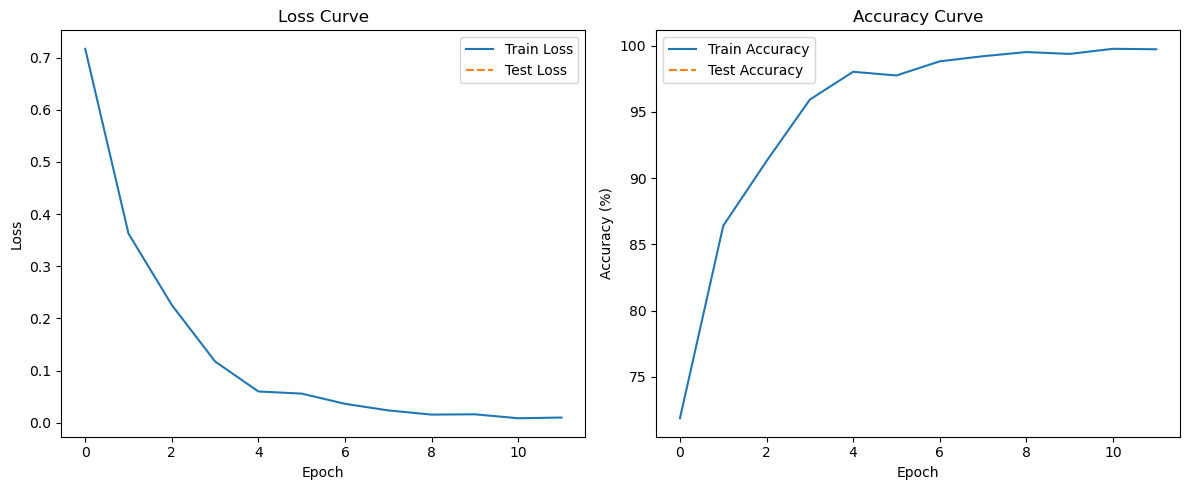

In [20]:
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
correct_train = 0
total_train = 0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = module(images)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print(f"Training Accuracy: {100 * correct_train / total_train:.2f}%")


Training Accuracy: 99.95%


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = module(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.93      0.95       300
  meningioma       0.93      0.93      0.93       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

Confusion Matrix:
[[280  19   0   1]
 [ 11 284   7   4]
 [  0   1 403   1]
 [  1   2   0 297]]


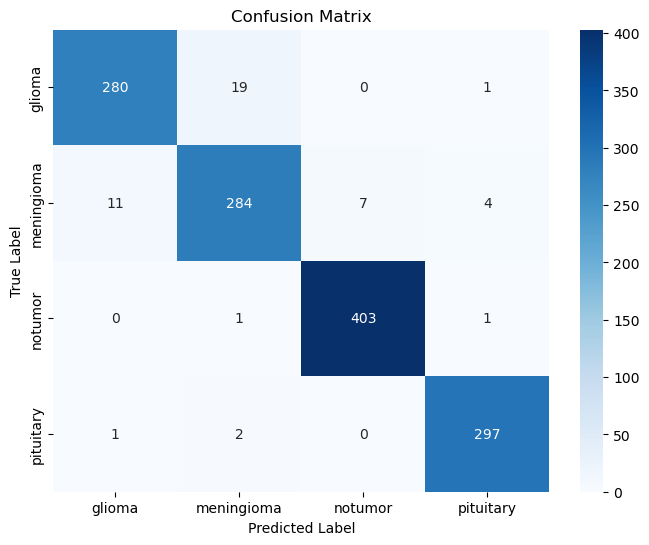

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Put the model in evaluation mode
module.eval()

# Define preprocessing pipeline (for grayscale image)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ✅ Make sure it's 1 channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load and preprocess the image
image = Image.open(r"C:\Users\Itcomplex\Desktop\Brain_Tumor_Project\images\glioma (1).jpg")
input_image = transform(image).unsqueeze(0)  # Add batch dimension [1, 1, 224, 224]

# Move image to device
input_image = input_image.to(device)

# Perform inference
with torch.no_grad():
    output = module(input_image)
    print("This is output:", output)
    predicted_class = torch.argmax(output, dim=1).item()

# Get class name from training dataset
class_name = train_dataset.classes[predicted_class]
print(f"Predicted Class ID: {predicted_class}, Class Name: {class_name}")


In [ ]:
torch.save(module.state_dict(),'BTD_model.pth')
print("Model is saved succesfully")

Model is saved succesfully


In [30]:
for i in range(0, len(test_dataset), 10):
    _, label = test_dataset[i]
    class_name = test_dataset.classes[label]
    print(f"Index: {i}, Label: {label}, Class Name: {class_name}")


Index: 0, Label: 0, Class Name: glioma
Index: 10, Label: 0, Class Name: glioma
Index: 20, Label: 0, Class Name: glioma
Index: 30, Label: 0, Class Name: glioma
Index: 40, Label: 0, Class Name: glioma
Index: 50, Label: 0, Class Name: glioma
Index: 60, Label: 0, Class Name: glioma
Index: 70, Label: 0, Class Name: glioma
Index: 80, Label: 0, Class Name: glioma
Index: 90, Label: 0, Class Name: glioma
Index: 100, Label: 0, Class Name: glioma
Index: 110, Label: 0, Class Name: glioma
Index: 120, Label: 0, Class Name: glioma
Index: 130, Label: 0, Class Name: glioma
Index: 140, Label: 0, Class Name: glioma
Index: 150, Label: 0, Class Name: glioma
Index: 160, Label: 0, Class Name: glioma
Index: 170, Label: 0, Class Name: glioma
Index: 180, Label: 0, Class Name: glioma
Index: 190, Label: 0, Class Name: glioma
Index: 200, Label: 0, Class Name: glioma
Index: 210, Label: 0, Class Name: glioma
Index: 220, Label: 0, Class Name: glioma
Index: 230, Label: 0, Class Name: glioma
Index: 240, Label: 0, Class